## hana_ml Tutorial - COVID-19
Author: SAP TI HA DB ML China

Date: 2020/5/21

In this tutorial, we will use SAP hana_ml to analyze the public dataset of COVID-19.

## Dataset
We use the public COVID-19 dataset from JHU, https://github.com/CSSEGISandData/COVID-19  (For tutorials only). 

## HANA Connection

First, create a connetion to SAP HANA. To create a such connection, a config file, config/e2edata.ini is used to control the connection parameters.A sample section in the config file is shown below which includes HANA url, port, user and password information.<br>

###################<br>
[hana]<br>
url=host-url<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
###################<br>


In [16]:
from hana_ml.dataframe import ConnectionContext
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = ConnectionContext(url, port, user, pwd)

Connection functions samples:

In [17]:
print(connection_context.connection.isconnected())
print(connection_context.has_table(table='T1'))
print(connection_context.get_current_schema())
print(connection_context.hana_version())

True
False
PAL_USER
4.50.000.00.1590354191 (master)


## hana_ml DataFrame

### 1. worldwide-aggregated dataset

In [19]:
import pandas as pd
from hana_ml.dataframe import create_dataframe_from_pandas
worldwide = pd.read_csv('../datasets/worldwide-aggregated.csv')
worldwide_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=worldwide, table_name='WORLD', force=True, replace=True)

In [20]:
worldwide_df

Coverts to Pandas dataframe with collect():

In [21]:
worldwide_df.head(3).collect()

,Date,Confirmed,Recovered,Deaths,Increase rate
0,1/22/2020,555,28,17,0.000000
1,1/23/2020,654,30,18,17.837838
2,1/24/2020,941,36,26,43.883792


In [22]:
worldwide_df.dtypes()

[('Date', 'NVARCHAR', 5000, 5000, 5000, 0),
 ('Confirmed', 'INT', 10, 10, 10, 0),
 ('Recovered', 'INT', 10, 10, 10, 0),
 ('Deaths', 'INT', 10, 10, 10, 0),
 ('Increase rate', 'DOUBLE', 15, 15, 15, 0)]

In [23]:
worldwide_df.columns

['Date', 'Confirmed', 'Recovered', 'Deaths', 'Increase rate']

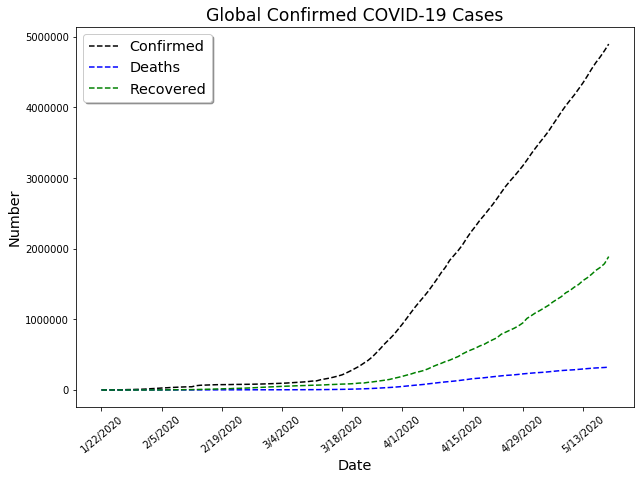

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Global Confirmed COVID-19 Cases', fontsize='xx-large')
ax.plot(worldwide['Date'], worldwide['Confirmed'], 'k--', label='Confirmed')
ax.plot(worldwide['Date'], worldwide['Deaths'], 'b--', label='Deaths')
ax.plot(worldwide['Date'], worldwide['Recovered'], 'g--', label='Recovered')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = worldwide['Date']
xticks=list(range(0,len(Date),14)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### 2. time_series_covid19_confirmed_US dataset

In [26]:
import numpy as np
# Load data, drop unneeded lat/long columns and group by country/region
def loadAndGroup(fileName, groupBy="Province_State", dropColumns=["UID","iso2","iso3","code3","FIPS","Admin2","Country_Region","Lat","Long_","Combined_Key"], extraDrop=[]):   #,"Population"
    df=pd.read_csv(fileName)
    for dc in dropColumns+extraDrop:
        df.drop(dc, axis=1, inplace=True)
    df=df.groupby(groupBy).sum()
    for dc in range(30):
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

def diff(ys):
    res=[0]
    cur=ys[0]
    for y in ys[1:]:
        res.append(y-cur)
        cur=y
    return res

confd         =loadAndGroup('../datasets/time_series_covid19_confirmed_US.csv')
confd         =confd.append(confd.sum(axis=0).rename('US'))
confdDelta    =confd.diff(axis=1).replace(np.nan, 0)

# Preprocess the Data to transpose and add a 'timestamp' column as the first column.
def preprocessData(df):
    df_new = pd.DataFrame(df).T
    id= df_new.index
    col_name=df_new.columns.tolist()
    col_name.insert(0, 'Timestamp')  
    df_new=df_new.reindex(columns=col_name)
    df_new['Timestamp']=id
    return(df_new)

confd_df=preprocessData(confd)
confdDelta_df=preprocessData(confdDelta)

confd_df_hana = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=confd_df, table_name='US_CONFIRMED', force=True, replace=True)
confdDelta_df_hana = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=confdDelta_df, table_name='US_CONFIRMED_DELTA', force=True, replace=True)

In [27]:
confd_us = connection_context.table('US_CONFIRMED')
confd_us_delta = connection_context.table('US_CONFIRMED_DELTA')
print(confd_us)
print(confd_us_delta)

In [28]:
confd_us.head(3).collect()

,Timestamp,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,US
0,2020-02-21,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15
1,2020-02-22,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15
2,2020-02-23,0,0,0,1,0,10,0,0,0,...,0,0,0,0,0,1,0,0,0,15


In [29]:
confd_us_delta.collect().head(3)

,Timestamp,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming,US
0,2020-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print(confd_us.count())
print(confd_us_delta.count())

89
89


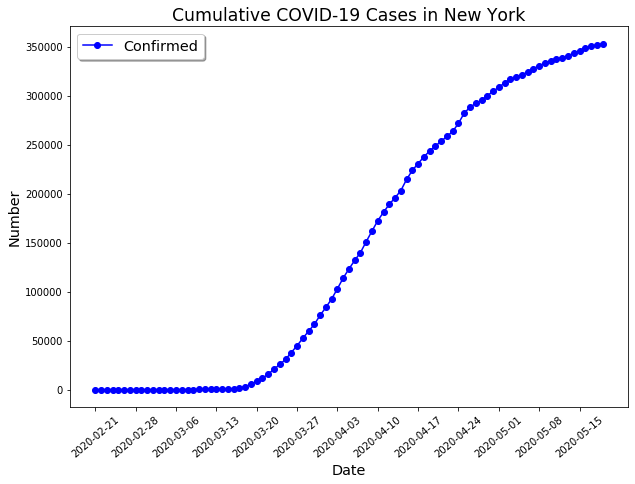

In [31]:
ny_confirmed = confd_us.select('New York').collect()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Cumulative COVID-19 Cases in New York', fontsize='xx-large')
ax.plot(confd_us.collect()['Timestamp'], ny_confirmed, 'b-o', label="Confirmed")
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

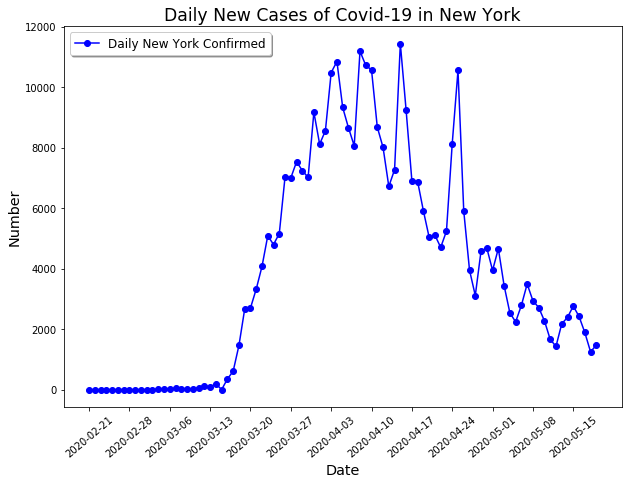

In [32]:
ny_confirmed_delta = confd_us_delta.select('New York').collect()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('Daily New Cases of Covid-19 in New York', fontsize='xx-large')
ax.plot(confd_us_delta.collect()['Timestamp'], ny_confirmed_delta, 'b-o', label="Daily New York Confirmed")
legend = ax.legend(loc='upper left', shadow=True, fontsize='large')
Date = confd_us_delta.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

## Forecast 

### Time Series Forecast Algorithms - Auto ARIMA, Additive Model Forecast

### Auto ARIMA

In [33]:
ny_confd_delta = confd_us_delta.select('New York').add_id('ID').cast('New York', 'INT')
print(ny_confd_delta.head(5).collect())

   ID  New York
0   1         0
1   2         0
2   3         0
3   4         0
4   5         0


In [34]:
from hana_ml.algorithms.pal.tsa.auto_arima import AutoARIMA

autoarima = AutoARIMA()
autoarima.fit(ny_confd_delta, key="ID")

print(autoarima.model_.collect().head(5))
print(autoarima.fitted_.collect().head(10))

  KEY                      VALUE
0   p                          3
1  AR  1.61789;-1.04121;0.333432
2   d                          1
3   q                          2
4  MA          -1.69531;0.804181
   ID  FITTED  RESIDUALS
0   1     NaN        NaN
1   2     0.0        0.0
2   3     0.0        0.0
3   4     0.0        0.0
4   5     0.0        0.0
5   6     0.0        0.0
6   7     0.0        0.0
7   8     0.0        0.0
8   9     0.0        0.0
9  10     0.0        0.0


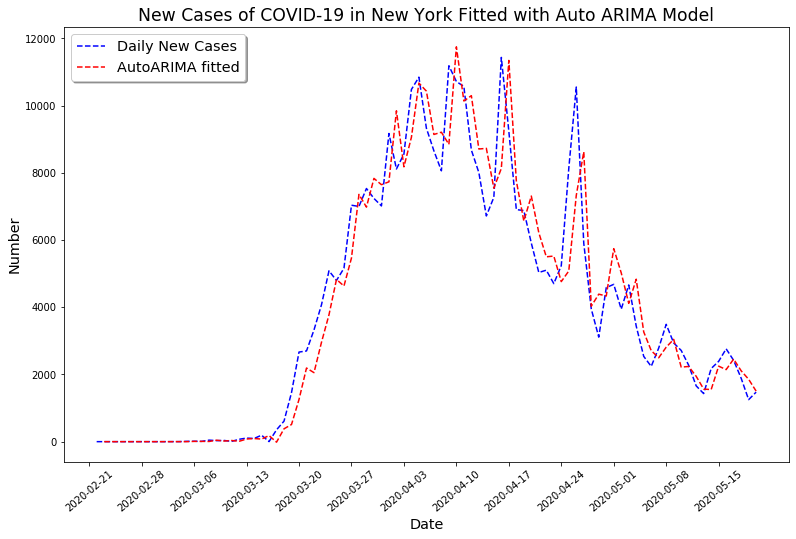

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Fitted with Auto ARIMA Model', fontsize='xx-large')
ax.plot(ny_confd_delta.collect()['ID'], ny_confd_delta.collect()['New York'], 'b--', label = 'Daily New Cases')
ax.plot(autoarima.fitted_.collect()['ID'], autoarima.fitted_.collect()['FITTED'],'r--', label='AutoARIMA fitted')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us_delta.collect()['Timestamp']
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### Model Storage

In [36]:
from hana_ml.model_storage import ModelStorage
# model storage must use the same connection as the model
model_storage = ModelStorage(connection_context=connection_context)

# Saves the model
autoarima.name = 'ARIMA model' 
autoarima.version = 1
model_storage.save_model(model=autoarima, if_exists='replace')

autoarima.name = 'ARIMA model' 
autoarima.version = 2
model_storage.save_model(model=autoarima, if_exists='replace')

# Lists models
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,MODEL_STORAGE_VER
0,ARIMA model,1,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2020-06-09 17:03:50,1
1,ARIMA model,2,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2020-06-09 17:03:52,1


In [37]:
model_storage.delete_model('ARIMA model', 2)
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,MODEL_STORAGE_VER
0,ARIMA model,1,PAL,hana_ml.algorithms.pal.tsa.auto_arima.AutoARIMA,"{""model_attributes"": {""seasonal_period"": null,...",2020-06-09 17:03:50,1


In [38]:
model_storage.list_models()['JSON'].iloc[0]

'{"model_attributes": {"seasonal_period": null, "seasonality_criterion": null, "d": null, "kpss_significance_level": null, "max_d": null, "seasonal_d": null, "ch_significance_level": null, "max_seasonal_d": null, "max_p": null, "max_q": null, "max_seasonal_p": null, "max_seasonal_q": null, "information_criterion": null, "search_strategy": null, "max_order": true, "initial_p": null, "initial_q": null, "initial_seasonal_p": null, "initial_seasonal_q": null, "guess_states": null, "max_search_iterations": null, "method": null, "allow_linear": null, "forecast_method": null, "output_fitted": true, "thread_ratio": null}, "artifacts": {"schema": "PAL_USER", "model_tables": "HANAML_ARIMA_MODEL_1_CLASS_HANA_ML_ALGORITHMS_PAL_TSA_AUTO_ARIMA_AUTOARIMA_MODELS", "library": "PAL"}}'

In [39]:
model = model_storage.load_model(name='ARIMA model', version=1)
print(model.model_.collect().head(5))

  KEY                      VALUE
0   p                          3
1  AR  1.61789;-1.04121;0.333432
2   d                          1
3   q                          2
4  MA          -1.69531;0.804181


### Predict with ARIMA Model 

In [40]:
model.set_conn(connection_context)
result = model.predict(forecast_length=5)
print(result.collect())

   TIMESTAMP     FORECAST           SE        LO80         HI80         LO95  \
0          0  1888.267252  1026.552483  572.686865  3203.847640  -123.738658   
1          1  2088.086131  1396.697693  298.145409  3878.026853  -649.391066   
2          2  2054.720660  1510.492072  118.946524  3990.494796  -905.789423   
3          3  1930.815541  1562.175596  -71.193719  3932.824800 -1130.992389   
4          4  1831.717159  1632.332838 -260.202254  3923.636572 -1367.596440   

          HI95  
0  3900.273163  
1  4825.563328  
2  5015.230743  
3  4992.623471  
4  5031.030757  


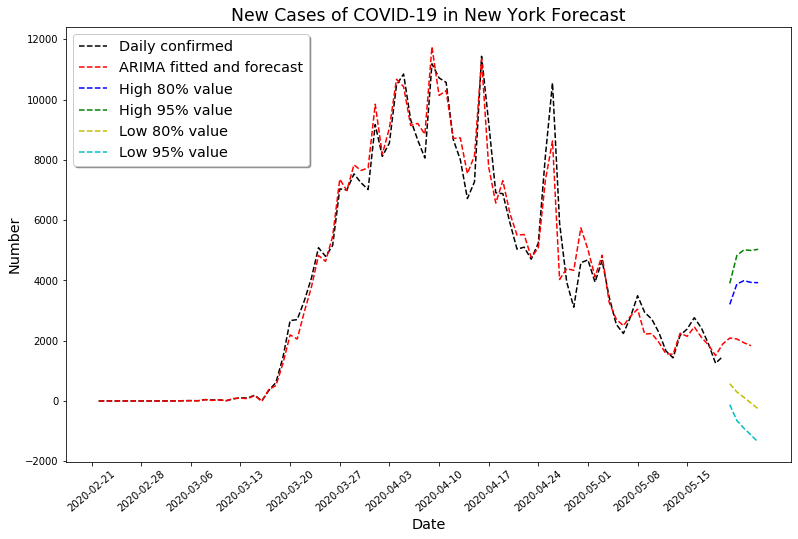

In [41]:
id_predict = list(range(90,95))
id_all = list(range(1,94))

data_fitted_predict = autoarima.fitted_.collect()['FITTED'].append(result.collect()['FORECAST'])
data_fitted = ny_confd_delta.collect()['New York']

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Forecast', fontsize='xx-large')
ax.plot(ny_confd_delta.collect()['ID'], data_fitted, 'k--', label='Daily confirmed')
ax.plot(id_all, data_fitted_predict[1:94], 'r--', label='ARIMA fitted and forecast')
ax.plot(id_predict,  result.collect()['HI80'], 'b--', label='High 80% value')
ax.plot(id_predict,  result.collect()['HI95'], 'g--', label='High 95% value')
ax.plot(id_predict,  result.collect()['LO80'], 'y--', label='Low 80% value')
ax.plot(id_predict,  result.collect()['LO95'], 'c--', label='Low 95% value')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
Date = confd_us_delta.collect()['Timestamp']
Date.append(pd.DataFrame(['5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20']))
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()

### Additive Model Forecast

In [42]:
ny_confd_delta = confd_us_delta.select('Timestamp','New York').cast('New York', 'INT')
ny_confd_delta = ny_confd_delta.cast('Timestamp', 'DATE')
print(ny_confd_delta.head(3).collect())
print(ny_confd_delta.dtypes())

    Timestamp  New York
0  2020-02-21         0
1  2020-02-22         0
2  2020-02-23         0
[('Timestamp', 'DATE', 10, 10, 10, 0), ('New York', 'INT', 10, 10, 10, 0)]


Predicted data:

In [43]:
from hana_ml.dataframe import create_dataframe_from_pandas
data = {
    'Timestamp':['2020-5-20', '2020-5-21', '2020-5-22', '2020-5-23', '2020-5-24'],
    'New York':[0, 0, 0, 0, 0]
}
predict = pd.DataFrame(data)
predict_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df= predict, table_name='ADDITIVE_PREDICT_TBL', force=True, replace=True)
predict_df = predict_df.cast('New York', 'DOUBLE')
predict_df = predict_df.cast('Timestamp', 'DATE')
print(predict_df.collect())
print(predict_df.dtypes())

    Timestamp  New York
0  2020-05-20       0.0
1  2020-05-21       0.0
2  2020-05-22       0.0
3  2020-05-23       0.0
4  2020-05-24       0.0
[('Timestamp', 'DATE', 10, 10, 10, 0), ('New York', 'DOUBLE', 15, 15, 15, 0)]


In [44]:
from hana_ml.algorithms.pal.tsa import additive_model_forecast

amf = additive_model_forecast.AdditiveModelForecast()
amf.fit(ny_confd_delta)

print(amf.model_.collect())

   ROW_INDEX                                      MODEL_CONTENT
0          0  {"FLOOR":0.0,"GROWTH":"linear","SEASONALITY_MO...


In [45]:
result = amf.predict(predict_df)
print(result.collect())

    Timestamp         YHAT   YHAT_LOWER    YHAT_UPPER
0  2020-05-20  6023.608932  1697.929777  10077.926549
1  2020-05-21  6229.385815  2112.136436  10463.727400
2  2020-05-22  6116.905847  1779.243775   9968.713326
3  2020-05-23  6297.310586  2109.184619  10461.900381
4  2020-05-24  5552.090529  1510.738599   9880.554423


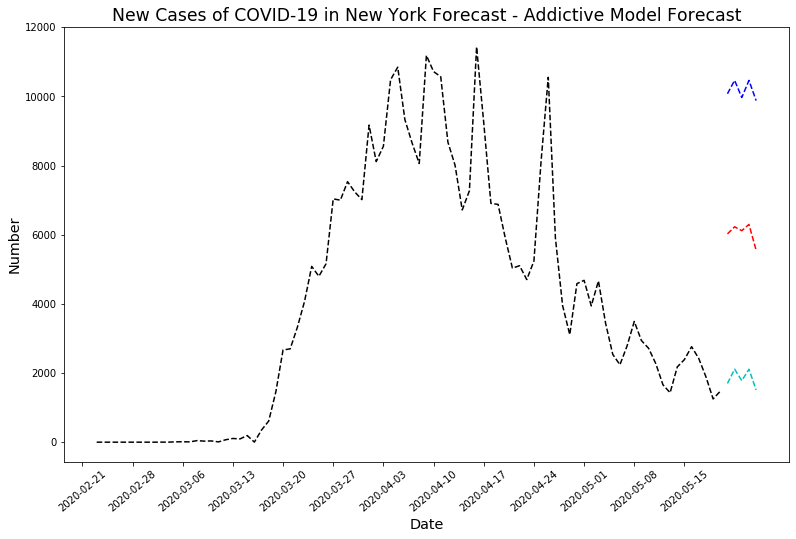

In [46]:
id_predict = list(range(90,95))
id_all = list(range(1,95))

data_all = ny_confd_delta.collect()['New York'].append(result.collect()['YHAT']) 
upper = result.collect()['YHAT_UPPER']
lower = result.collect()['YHAT_LOWER']

fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.set_ylabel('Number', fontsize='x-large')
ax.set_xlabel('Date', fontsize='x-large')
ax.set_title('New Cases of COVID-19 in New York Forecast - Addictive Model Forecast', fontsize='xx-large')
ax.plot(id_all[1:89], data_all[1:89], 'k--', label='confirmed')
ax.plot(id_all[89:94], data_all[89:94], 'r--', label='predict data')
ax.plot(id_predict,  upper, 'b--', label='upper bound')
ax.plot(id_predict,  lower, 'c--', label='lower bound')
Date = confd_us_delta.collect()['Timestamp']
Date.append(pd.DataFrame(['5/20/20', '5/21/20', '5/22/20', '5/23/20', '5/24/20']))
xticks=list(range(0,len(Date),7)) 
xlabels=[Date[x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
plt.show()
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

### Regression - SVR

In [47]:
ny_confd_delta = confd_us_delta.select('New York').cast('New York', 'INT')
print(ny_confd_delta.head(3).collect())
print(ny_confd_delta.dtypes())

   New York
0         0
1         0
2         0
[('New York', 'INT', 10, 10, 10, 0)]


In [48]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
values = pd.DataFrame(ny_confd_delta.collect()['New York'])
regression_data = series_to_supervised(values, 5)
print(regression_data.head(5))

   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
5        0.0        0.0        0.0        0.0        0.0        0
6        0.0        0.0        0.0        0.0        0.0        0
7        0.0        0.0        0.0        0.0        0.0        0
8        0.0        0.0        0.0        0.0        0.0        0
9        0.0        0.0        0.0        0.0        0.0        0


In [49]:
svr_df = create_dataframe_from_pandas(connection_context=connection_context, pandas_df=regression_data, table_name='NY_SVR_DATA_TBL', force=True, replace=True)
svr_df =svr_df.add_id('ID')
print(svr_df.head(3).collect())

   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   1        0.0        0.0        0.0        0.0        0.0        0
1   2        0.0        0.0        0.0        0.0        0.0        0
2   3        0.0        0.0        0.0        0.0        0.0        0


### Model Training
Split the dataset into train_data and test_data:

In [50]:
from hana_ml.algorithms.pal.partition import train_test_val_split
train_data, test_data, validate_data = train_test_val_split(svr_df, training_percentage=0.8, testing_percentage=0.2, validation_percentage=0)
print(train_data.count())
print(train_data.collect().head(3))
print(test_data.count())
print(test_data.collect().head(3))

67
   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   1        0.0        0.0        0.0        0.0        0.0        0
1   3        0.0        0.0        0.0        0.0        0.0        0
2   4        0.0        0.0        0.0        0.0        0.0        0
17
   ID  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)
0   2        0.0        0.0        0.0        0.0        0.0        0
1   6        0.0        0.0        0.0        0.0        0.0        1
2  13        9.0       12.0        8.0       45.0       30.0       36


In [51]:
from hana_ml.algorithms.pal.svm import SVR
featurs_svr = ['var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']
svr = SVR(kernel = 'rbf',
          scale_info='standardization', 
          gamma = 0.3,
          random_state=10,
          scale_label=True)
svr.fit(train_data, key='ID', features = featurs_svr, label = 'var1(t)')

print(svr.model_.collect())
print(svr.stat_.collect())

   ROW_INDEX                                      MODEL_CONTENT
0          0  {"C":100.0,"CONTENT":"{\"impute_model\":{\"col...
1          1  037686,1.0865289304171852,1.0869229053964538,1...
2          2  :90,"prob":0.0040650406504065045},{"index":91,...
3          3  0f\u0002S,\u0007O0\u0000o\u001a4BXP$NQ]J3!\t\u...
  STAT_NAME          STAT_VALUE
0       obj  -94.28637474245049
1      iter                1999


### Model Score
Calculate the r2_score:

In [52]:
print(svr.score(test_data, key='ID', features = featurs_svr, label = 'var1(t)'))

0.8759670472740243


### Cross Validation

In [53]:
svr_cv = SVR(kernel='rbf', 
             scale_info='standardization', 
             scale_label=True, 
             resampling_method='cv',
             fold_num=10, 
             repeat_times=5,
             random_state=11,
             search_strategy='grid',
             param_range = [('gamma', [0.1, 0.1, 1.0])])
svr_cv.fit(train_data, key='ID', features = featurs_svr, label = 'var1(t)')

print(svr_cv.model_.collect())
print(svr_cv.stat_.collect())

   ROW_INDEX                                      MODEL_CONTENT
0          0  {"C":100.0,"CONTENT":"{\"impute_model\":{\"col...
1          1  ,1.078442624060443,1.0827535584770451,1.087064...
2          2  968992248062},{"index":91,"prob":0.00387596899...
3          3  2},{"index":210,"prob":0.003875968992248062}],...
         STAT_NAME                                         STAT_VALUE
0          timeout                                              FALSE
1      TEST_1_RMSE  2638.14, 2700.35, 2031.05, 2047.2, 3260.21, 29...
2      TEST_2_RMSE  2571.35, 2052.49, 2624.77, 2418.51, 2216.73, 3...
3      TEST_3_RMSE  3250.79, 3545.19, 2733.98, 3250.38, 2406.28, 1...
4      TEST_4_RMSE  2534.54, 3461.75, 1787.58, 1261.42, 2291.39, 3...
5      TEST_5_RMSE  2448.88, 2186.67, 1403.91, 4339.25, 2797.65, 1...
6   TEST_RMSE.MEAN                                            2597.59
7    TEST_RMSE.VAR                                             473515
8   EVAL_RESULTS_1  {"candidates":[{"TEST_RMSE":[[

In [54]:
print(svr_cv.score(test_data, key='ID', features = featurs_svr, label = 'var1(t)'))

0.8079732525176111


## Close HANA Connection

In [135]:
connection_context.close()